Initialization

In [4]:
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp,Operator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector,random_statevector
import math
import json
import os
import random

GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
CYAN = "\033[96m"
MAGENTA = "\033[95m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
STANDARD = "\033[0m"

%run config.py

Load the directories and identify the project inside them.

In [5]:
def rotfitness(parameters, *args):
	qbits=int(len(parameters)/3)

	qc = QuantumCircuit(qbits)
	for i in range(qbits):
		qc.rx(float(parameters[3*i]), i)
		qc.ry(float(parameters[3*i+1]), i)
		qc.rz(float(parameters[3*i+2]), i)
	
	# print (qc.draw())
	qc=qc.reverse_bits()

	complexArray = []
	complexArray.append(complex(1,0))
	for i in range(2**qbits-1):
		complexArray.append(complex(0,0))

	sv = Statevector(complexArray)
	sv = sv.evolve(qc)

	outlistcomplex = sv.data.tolist()
	# print(outlistcomplex)
	# print (args)

	sigma = 0.0
	for i in range(len(outlistcomplex)):
		sigma  += abs( args[i].real - outlistcomplex[i].real)
		sigma  += abs( args[i].imag - outlistcomplex[i].imag)

	sigma = sigma/len(outlistcomplex)
	# print (sigma)
	return sigma

In [6]:
def guessrotations(target):
	# target is a statevector
	length = len(target)
	qbits = int(math.log2(length))
	# print (qbits)
	initial_guess = [1.0,] * 3*qbits
	# print(initial_guess)
	result = minimize(rotfitness, initial_guess, args=tuple(target))
	return result.x.tolist()

In [7]:
# List all the directories, only the directories
dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
activeproj = {}
base = ""
for d in dirs:
	if os.path.exists(d+"/active"):
		with open(d+"/active","r") as f:
			ptype = f.read().strip()
			activeproj[d] = ptype
		if os.path.exists(d+"/base"):
			base = d
			if ptype != "qiskit":
				print("Warning: base project is not of type qiskit")
		
# print("Active projects: ",activeproj)
# print("Static data: ",staticdata)
# print("Base project: ",base)

In [8]:
def getRandomStateVectorWhole(qbits):
	sv=random_statevector(2**qbits)
	rot=guessrotations(sv)
	return sv,rot

In [9]:
def getRandomStateVectorRotations(qbits):
	states=[]
	rots=[]
	for i in range(qbits):
		# Random rotation 0 4pi
		theta = 2*math.pi*random.random()
		phi = 2 *math.pi*random.random()

		rot=[theta,phi,0]

		qc = QuantumCircuit(1)
		qc.rx(theta, 0)
		qc.ry(phi, 0)
	
		complexArray = []
		complexArray.append(complex(1,0))
		complexArray.append(complex(0,0))

		sv = Statevector(complexArray)
		sv = sv.evolve(qc)

		states.append(sv)
		rots.append(rot)

	rot=[]
	for i in range(qbits):
		rot+=rots[i]

	sv=states[0]
	for i in range(1,qbits):
		newsv=[]
		for j in range(len(sv.data)):
			for k in range(2):
				newsv.append(sv.data[j]*states[i].data[k])
		sv=Statevector(newsv)

	print(sv)
	return sv,rot

In [10]:
def getRandomStateVectorSingle(qbits):
	states=[]
	rots=[]
	for i in range(qbits):
		sv=random_statevector(2**qbits)
		# sv= Statevector([1/math.sqrt(2), 1j/math.sqrt(2)])
		# sv= Statevector([0, 1])
		states.append(sv)
		print ("State: ",sv)
		ai = sv.data[0].imag
		ar = sv.data[0].real
		bi = sv.data[1].imag
		br = sv.data[1].real
		d2 = br**2+ai**2
		print ("d2: ",d2)
		c2 = ai**2/(d2)
		print ("c2: ",c2)
		phi = 2.0*math.asin(math.sqrt(d2))
		print ("phi: ",phi)
		theta = 2.0* math.asin(math.sqrt(c2))
		print ("theta: ",theta)
		print ("rx:")
		print ( math.cos(theta/2), "-i",math.sin(theta/2))
		print ( "-i", math.sin(theta/2), math.cos(theta/2))

		print ("ry:")
		print ( math.cos(phi/2), "-",math.sin(phi/2))
		print ( math.sin(phi/2), math.cos(phi/2))

		g0ar = math.cos(theta/2)
		g0bi = math.sin(theta/2)
		print ("g0 = rx * 0")
		print (g0ar, "-i",g0bi)

		print ("g1 = ry * g0")
		

		rot = [theta,phi,0]
	# sv=random_statevector(2**qbits)
	# rot=guessrotations(sv)
	return sv,rot

# getRandomStateVector(2)

Create a set of inputs for the test cases. They should be normalized values, let's use the qiskit random_statevector function to generate them.

In [11]:
if fundamental:
	inputs = []
	rots = []
	outlist=[[1.0,0.0]]
	rotlist=[0.0,] * 3 * qbits
	for i in range(2**qbits-1):
		outlist.append([0.0,0.0])
	inputs.append(outlist)
	rots.append(rotlist)

	with open('inputs.json', 'w') as f:
		json.dump(inputs, f)

	with open('rots.json', 'w') as f:
		json.dump(rots, f)
else:
	if staticdata:
		with open('inputs.json', 'r') as f:
			inputs = json.load(f)
		with open('rots.json', 'r') as f:
			rots = json.load(f)
	else:
		inputs = []
		rots = []
		for i in range(numiter):
			sv,rot=getRandomStateVectorRotations(qbits)
			outlist=[]
			for i in range(len(sv)):
				outlist.append([sv[i].real,sv[i].imag])
			rots.append(rot)
			inputs.append(outlist)


		with open('inputs.json', 'w') as f:
			json.dump(inputs, f)

		with open('rots.json', 'w') as f:
			json.dump(rots, f)

Statevector([-0.39068127-0.41043111j,  0.26062756+0.08310443j,
             -0.29843108+0.63312092j, -0.02056447-0.33727626j],
            dims=(2, 2))
Statevector([-0.6400688 -0.24816951j,  0.36082316-0.49674384j,
              0.05894743+0.28434572j, -0.25933154-0.01399625j],
            dims=(2, 2))
Statevector([-2.11995651e-01-0.00546404j,  2.00876936e-04+0.96947983j,
              2.60812005e-02+0.00331155j,  1.20371349e-02-0.11958563j],
            dims=(2, 2))


Convert the inputs to the format expected by the single project.

In [12]:
for p in activeproj:
	if activeproj[p] == "qiskit" or activeproj[p] == "pennylane" or activeproj[p] == "spinqsim" or activeproj[p] == "spinq":
		inputsJson = []
		for i in inputs:
			inputJson=[]
			for j in i:
				val= [j[0], j[1]]
				inputJson.append(val)
			inputsJson.append( inputJson )

		with open(p+'/inputs.json', 'w') as f:
			json.dump(inputsJson, f)
		with open(p+'/rots.json', 'w') as f:
			json.dump(rots, f)

	if activeproj[p] == "bmqsim":
		inputsJson = []
		for i in inputs:
			inputJson=[]
			for j in i:
				val= {"Real": j[0], "Imag": j[1]}
				inputJson.append(val)
			inputsJson.append({ "Vector": inputJson })

		with open(p+'/inputs.json', 'w') as f:
			json.dump(inputsJson, f)
		with open(p+'/rots.json', 'w') as f:
			json.dump(rots, f)

	if activeproj[p] == "bmqsim_hw" or activeproj[p] == "quest":
		inputValues=[]
		for i in inputs:
			for j in i:
				inputValues.append(j[0])
				inputValues.append(j[1])

		with open(p+'/inputs.txt', 'w') as f:
			for item in inputValues:
				f.write("%s\n" % item)
		with open(p+'/rots.json', 'w') as f:
			json.dump(rots, f)
			

Run all the projects

In [13]:
for p in activeproj:	
	cwd = os.getcwd()
	os.chdir(p)
	if os.path.exists("circuit.py"):
		if activeproj[p] == "spinqsim" or activeproj[p] == "spinq":
			! source /tools/Conda/etc/profile.d/conda.sh && conda activate spinq && python circuit.py && conda deactivate
		elif activeproj[p] == "pennylane":
			! source /tools/Conda/etc/profile.d/conda.sh && conda activate pennylane && python circuit.py && conda deactivate
		else:
			%run circuit.py
	elif os.path.exists("circuit.ipynb"):
		%run circuit.ipynb
	os.chdir(cwd)

[{"Vector": [{"Real": -0.390681266203592, "Imag": -0.41043111378929203}, {"Real": 0.2606275608481342, "Imag": 0.08310442666372468}, {"Real": -0.29843108230972826, "Imag": 0.6331209161002391}, {"Real": -0.02056447436038769, "Imag": -0.3372762591238883}]}, {"Vector": [{"Real": -0.6400687960459668, "Imag": -0.24816951343873273}, {"Real": 0.36082315889231187, "Imag": -0.49674384100860164}, {"Real": 0.058947434054426484, "Imag": 0.28434572153965215}, {"Real": -0.2593315425396296, "Imag": -0.01399625161798182}]}, {"Vector": [{"Real": -0.21199565066388715, "Imag": -0.0054640417926371315}, {"Real": 0.0002008769355780007, "Imag": 0.9694798275554641}, {"Real": 0.026081200497097206, "Imag": 0.003311549317168715}, {"Real": 0.012037134898604729, "Imag": -0.11958563443637808}]}]%block code1 .sequential
        qbits   q0,q1
        zero    q0,q1
	h	q0
        cx      q0,q1
%endblock

%meta bmdef global main:code1
[{"Vector":[{"Real":-0.48727602,"Imag":0.15746546},{"Real":0.16975023,"Imag":-0.1797266

OUTPUT checks the output of the projects and compares them with the pivot project.


In [14]:
passed = True
passwdProjects = {}
allprobs = {}
for p in activeproj:
	if (activeproj[p] == "qiskit" and p==base):
		with open(p+'/outputs.json', 'r') as f:
			qiskitoutputs = json.load(f)

		probs = []

		for i in range(len(qiskitoutputs)):
			qiskitoutput = qiskitoutputs[i]
			prob = []
			for j in range(len(qiskitoutput)):
				qreal = float(qiskitoutput[j][0])
				qimag = float(qiskitoutput[j][1])
				prob.append(pow(qreal,2)+pow(qimag,2))
			probs.append(prob)

		allprobs[p] = probs

		with open(p+'/probs.json', 'w') as f:
			json.dump(probs, f)
		allprobs[p] = probs

	if (activeproj[p] == "qiskit" and p!=base) or activeproj[p] == "spinqsim" or activeproj[p] == "pennylane":
		with open(base+'/outputs.json', 'r') as f:
			qiskitoutputs = json.load(f)

		with open(p+'/outputs.json', 'r') as f:
			outputs = json.load(f)

		if len(qiskitoutputs) != len(outputs):
			print("Warning: Different number of outputs")

		qvars = []
		
		probs = []

		for i in range(len(qiskitoutputs[0])):
			qvars.append([0,0])

		for i in range(len(qiskitoutputs)):
			qiskitoutput = qiskitoutputs[i]
			spinqoutput = outputs[i]
			prob = []
			for j in range(len(qiskitoutput)):
				qreal = float(qiskitoutput[j][0])
				qimag = float(qiskitoutput[j][1])
				qreal2 = float(spinqoutput[j][0])
				qimag2 = float(spinqoutput[j][1])
				if useprob:
					qvars[j][0] += pow(pow(qreal,2)+pow(qimag,2)-pow(qreal2,2)-pow(qimag2,2),2)
				else:
					qvars[j][0] += pow(qreal - qreal2, 2)
					qvars[j][1] += pow(qimag - qimag2, 2)

				prob.append(pow(qreal,2)+pow(qimag,2))
			probs.append(prob)

		with open(p+'/probs.json', 'w') as f:
			json.dump(probs, f)
		allprobs[p] = probs

		for i in range(len(qvars)):
			qvars[i][0] = pow(qvars[i][0]/len(qiskitoutputs), 0.5)
			qvars[i][1] = pow(qvars[i][1]/len(qiskitoutputs), 0.5)
			if qvars[i][0] > passthreshold or qvars[i][1] > passthreshold:
				passed = False
				passwdProjects[p] = False

		if not quiet:
			print("Average error on "+p+":")
			print(json.dumps(qvars, indent=4))
		
		if p not in passwdProjects:
			passwdProjects[p] = True

	if activeproj[p] == "spinq":
		if not useprob:
			panic("spinq only supports useprob mode")

		with open(base+'/outputs.json', 'r') as f:
			qiskitoutputs = json.load(f)

		with open(p+'/probs.json', 'r') as f:
			probs = json.load(f)
		allprobs[p] = probs

		if len(qiskitoutputs) != len(probs):
			print("Warning: Different number of outputs")

		qvars = []

		for i in range(len(qiskitoutputs[0])):
			qvars.append([0,0])

		for i in range(len(qiskitoutputs)):
			qiskitoutput = qiskitoutputs[i]
			spinqoutput = probs[i]
			for j in range(len(qiskitoutput)):
				qreal = float(qiskitoutput[j][0])
				qimag = float(qiskitoutput[j][1])
				prob = float(spinqoutput[j])
				if useprob:
					qvars[j][0] += pow(pow(qreal,2)+pow(qimag,2)-prob,2)

		for i in range(len(qvars)):
			qvars[i][0] = pow(qvars[i][0]/len(qiskitoutputs), 0.5)
			qvars[i][1] = pow(qvars[i][1]/len(qiskitoutputs), 0.5)
			if qvars[i][0] > passthreshold or qvars[i][1] > passthreshold:
				passed = False
				passwdProjects[p] = False

		if not quiet:
			print("Average error on "+p+":")
			print(json.dumps(qvars, indent=4))

		if p not in passwdProjects:
			passwdProjects[p] = True
			
	if activeproj[p] == "bmqsim":
		
		with open(base+'/outputs.json', 'r') as f:
			qiskitoutputs = json.load(f)

		with open(p+'/outputs.json', 'r') as f:
			bmqsimoutputs = json.load(f)

		if len(qiskitoutputs) != len(bmqsimoutputs):
			print("Warning: Different number of outputs")

		bmvars = []
		probs = []
		for i in range(len(qiskitoutputs[0])):
			bmvars.append([0,0])

		for i in range(len(qiskitoutputs)):
			qiskitoutput = qiskitoutputs[i]
			bmqsimoutput = bmqsimoutputs[i]["Vector"]
			prob = []
			for j in range(len(qiskitoutput)):
				qreal = float(qiskitoutput[j][0])
				qimag = float(qiskitoutput[j][1])
				breal = float(bmqsimoutput[j]["Real"])
				bimag = float(bmqsimoutput[j]["Imag"])
				if useprob:
					bmvars[j][0] += pow(pow(qreal,2)+pow(qimag,2)-pow(breal,2)-pow(bimag,2),2)
				else:
					bmvars[j][0] += pow(qreal - breal, 2)
					bmvars[j][1] += pow(qimag - bimag, 2)

				prob.append(pow(breal,2)+pow(bimag,2))
			probs.append(prob)

		with open(p+'/probs.json', 'w') as f:
			json.dump(probs, f)
		allprobs[p] = probs

		for i in range(len(bmvars)):
			bmvars[i][0] = pow(bmvars[i][0]/len(qiskitoutputs), 0.5)
			bmvars[i][1] = pow(bmvars[i][1]/len(qiskitoutputs), 0.5)
			if bmvars[i][0] > passthreshold or bmvars[i][1] > passthreshold:
				passed = False
				passwdProjects[p] = False

		if not quiet:
			print("Average error on "+p+":")
			print(json.dumps(bmvars, indent=4))

		if p not in passwdProjects:
			passwdProjects[p] = True

	if activeproj[p] == "bmqsim_hw" or activeproj[p] == "quest":
		with open(base+'/outputs.json', 'r') as f:
			qiskitoutputs = json.load(f)

		with open(p+'/outputs.txt', 'r') as f:
			bmqsimoutputs = []
			for k in range(len(qiskitoutputs)):
				bmqsimoutput=[]
				for i in range(2 ** qbits):
					line = f.readline()
					vreal=float(line)
					line = f.readline()
					vimm=float(line)
					bmqsimoutput.append([vreal,vimm])
				bmqsimoutputs.append(bmqsimoutput)

		if len(qiskitoutputs) != len(bmqsimoutputs):
			print("Warning: Different number of outputs")

		bmvars = []
		probs = []

		for i in range(len(qiskitoutputs[0])):
			bmvars.append([0,0])

		for i in range(len(qiskitoutputs)):
			qiskitoutput = qiskitoutputs[i]
			bmqsimoutput = bmqsimoutputs[i]
			prob = []
			for j in range(len(qiskitoutput)):
				qreal = float(qiskitoutput[j][0])
				qimag = float(qiskitoutput[j][1])
				breal = float(bmqsimoutput[j][0])
				bimag = float(bmqsimoutput[j][1])
				if useprob:
					bmvars[j][0] += pow(pow(qreal,2)+pow(qimag,2)-pow(breal,2)-pow(bimag,2),2)
				else:
					bmvars[j][0] += pow(qreal - breal, 2)
					bmvars[j][1] += pow(qimag - bimag, 2)
				prob.append(pow(breal,2)+pow(bimag,2))
			probs.append(prob)

		for i in range(len(bmvars)):
			bmvars[i][0] = pow(bmvars[i][0]/len(qiskitoutputs), 0.5)
			bmvars[i][1] = pow(bmvars[i][1]/len(qiskitoutputs), 0.5)
			if bmvars[i][0] > passthreshold or bmvars[i][1] > passthreshold:
				passed = False
				passwdProjects[p] = False
		with open(p+'/probs.json', 'w') as f:
			json.dump(probs, f)
		allprobs[p] = probs
			
		if not quiet:
			print("Average error on "+p+":")
			print(json.dumps(bmvars, indent=4))

		if p not in passwdProjects:
			passwdProjects[p] = True

Average error on bmqsim:
[
    [
        8.257995920099409e-09,
        0.0
    ],
    [
        3.475072704859035e-08,
        0.0
    ],
    [
        6.882836816985288e-08,
        0.0
    ],
    [
        1.758480169004391e-08,
        0.0
    ]
]
Average error on spinqq:
[
    [
        0.0676841563167592,
        0.0
    ],
    [
        0.04868056855729546,
        0.0
    ],
    [
        0.0617216735059377,
        0.0
    ],
    [
        0.08773782716409308,
        0.0
    ]
]
Average error on bmqsim_hw:
[
    [
        8.818931945645093e-09,
        0.0
    ],
    [
        2.3666000564411314e-08,
        0.0
    ],
    [
        5.658262111963917e-08,
        0.0
    ],
    [
        2.220511317990191e-08,
        0.0
    ]
]
Average error on pennylane:
[
    [
        1.3809845625321524e-17,
        0.0
    ],
    [
        1.6024689053196365e-17,
        0.0
    ],
    [
        2.4037033579794548e-17,
        0.0
    ],
    [
        3.205728669380773e-17,
        0.0


In [15]:
if not quiet:
	if passed:
		print(f"{CYAN}Overall{STANDARD}: {GREEN}Passed{STANDARD}")
	else:
		print(f"Overall: {RED}Failed{STANDARD}")
	print ("")
	print (f"{CYAN}Detailed results{STANDARD}:")
	for p in passwdProjects:
		if passwdProjects[p]:
			print(f"\t{MAGENTA}"+p+f"{STANDARD}"+f": {GREEN}Passed{STANDARD}")
		else:
			print(f"\t{MAGENTA}"+p+f"{STANDARD}"+f": {RED}Failed{STANDARD}")

Overall: Passed

Detailed results:
	bmqsim: Passed
	spinqq: Passed
	bmqsim_hw: Passed
	pennylane: Passed
	quest: Passed
	spinq: Passed
	bmqsim_alveo: Passed
	qiskitrot: Passed


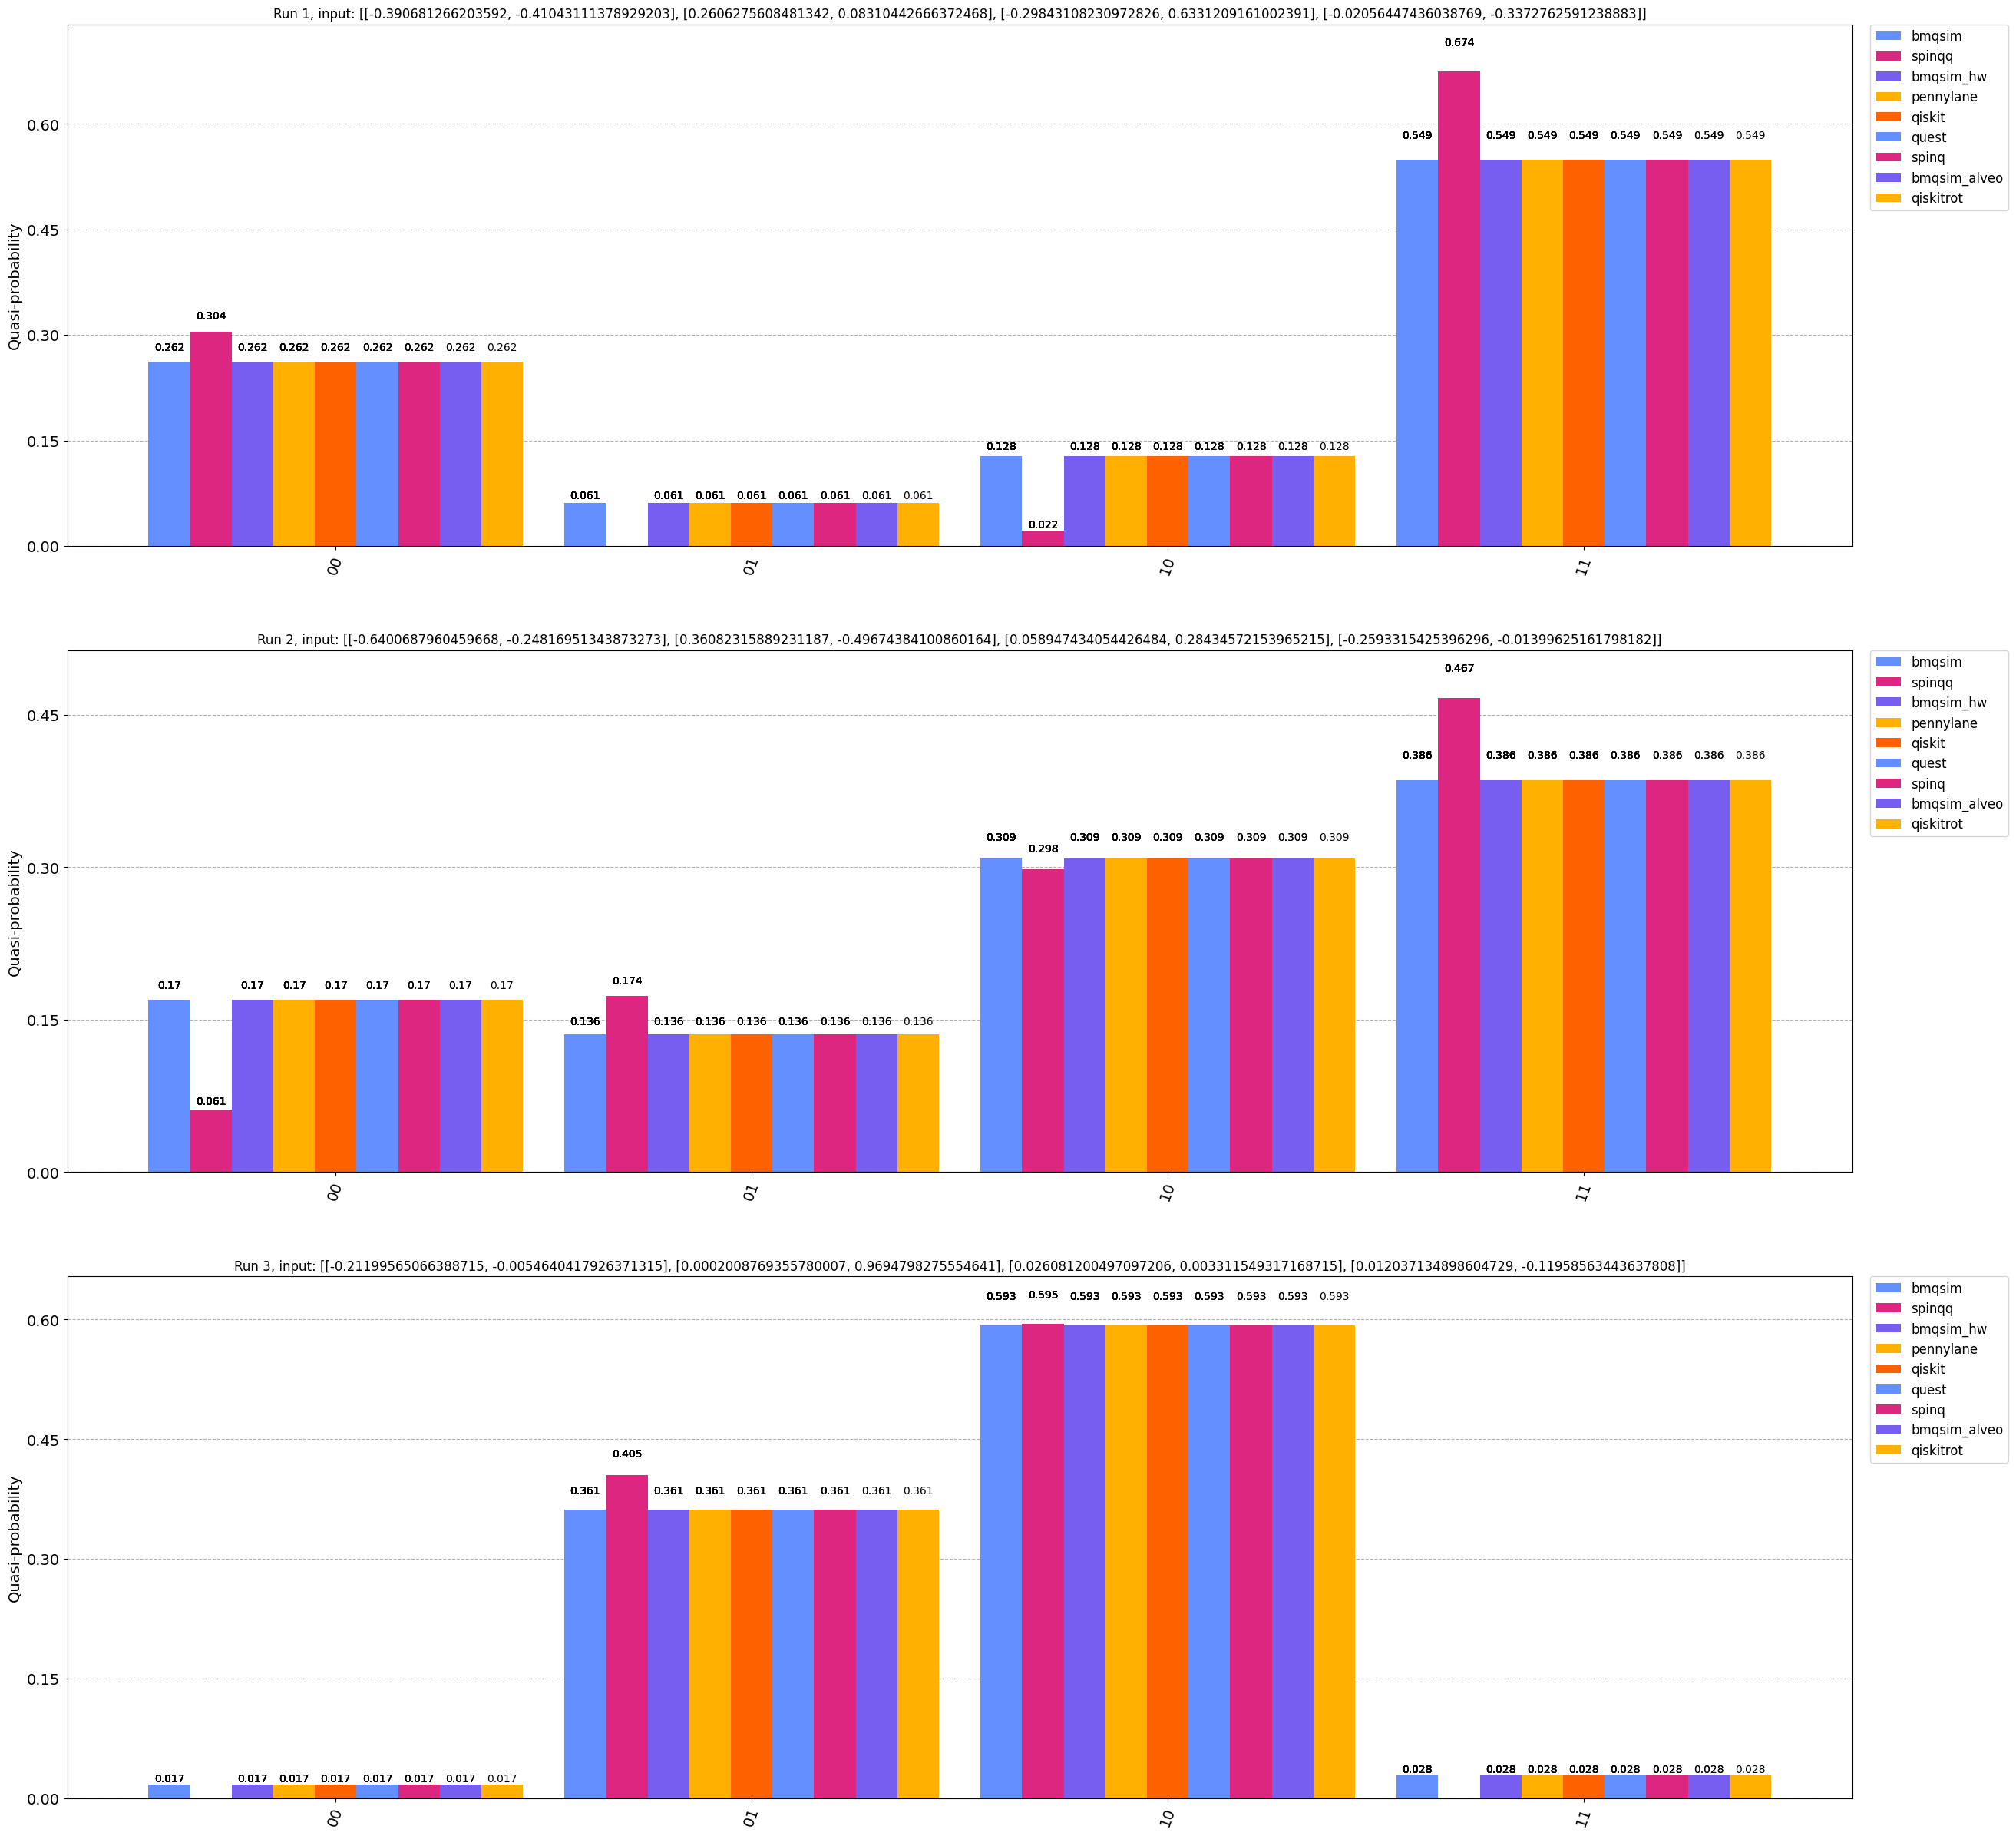

In [17]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(30,10*numiter)

for run in range(numiter):
        probviews = {}
        problist = []
        legend = []
        for p in activeproj:
                probviews[p] = {}
                problist.append(probviews[p])
                legend.append(p)
                for i in range(2**qbits):
                        if qbits == 1:
                                probviews[p][f"{i:01b}"] = allprobs[p][run][i]
                        elif qbits == 2:
                                probviews[p][f"{i:02b}"] = allprobs[p][run][i]

        ax = fig.add_subplot(numiter,1, run+1)
        ax.set_title(f"Run {run+1}, input: {inputs[run]}")
        plot_histogram(problist, legend=legend, ax=ax)
